In [ ]:
# Google Colab에서 Kaggle API를 사용하기 위한 라이브러리 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()

In [ ]:
# Kaggle API 토큰을 사용자 디렉토리로 복사하고 권한 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle에서 데이터셋 다운로드
!kaggle datasets download -d falgunipatel19/biomedical-text-publication-classification

 88% 49.0M/55.9M [00:01<00:00, 50.2MB/s]
100% 55.9M/55.9M [00:01<00:00, 51.7MB/s]


In [ ]:
!ls

biomedical-text-publication-classification.zip	kaggle.json  sample_data


In [ ]:
# 다운로드한 데이터셋 압축 해제
!unzip biomedical-text-publication-classification.zip

Archive:  biomedical-text-publication-classification.zip
  inflating: alldata_1_for_kaggle.csv  


In [ ]:
# transformers 라이브러리 설치
!pip install transformers

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split

# CSV 파일에서 데이터 불러오기
file_path = 'alldata_1_for_kaggle.csv'
train_df = pd.read_csv(file_path, encoding='ISO-8859-1',on_bad_lines='error')

In [ ]:
# 데이터프레임의 열 이름 출력
print(train_df.columns)

Index(['Unnamed: 0', '0', 'a'], dtype='object')


In [ ]:
# 텍스트 데이터 토큰화
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_column = 'a'
train_encodings = tokenizer(list(train_df[text_column]), truncation=True, padding=True, max_length=256, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch

# 클래스 레이블 정의
class_labels = train_df['0']

In [ ]:
# 클래스 레이블을 숫자 형식으로 변환
label_mapping = {'Thyroid_Cancer': 0, 'Colon_Cancer': 1, 'Lung_Cancer': 2}
numeric_labels = class_labels.map(label_mapping)

In [ ]:
# TensorDataset 생성
dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(numeric_labels))

In [ ]:
# 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# DataLoader 정의
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# DistilBERT 모델 초기화
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Optimizer 정의
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
!pip install matplotlib

Epoch 1: 100%|██████████| 757/757 [1:36:08<00:00,  7.62s/it]


Epoch 1, Average Training Loss: 0.3195674267844783
Model saved at: distilbert_model_epoch_1.pt


Epoch 2: 100%|██████████| 757/757 [1:35:51<00:00,  7.60s/it]


Epoch 2, Average Training Loss: 0.08821457721489202
Model saved at: distilbert_model_epoch_2.pt


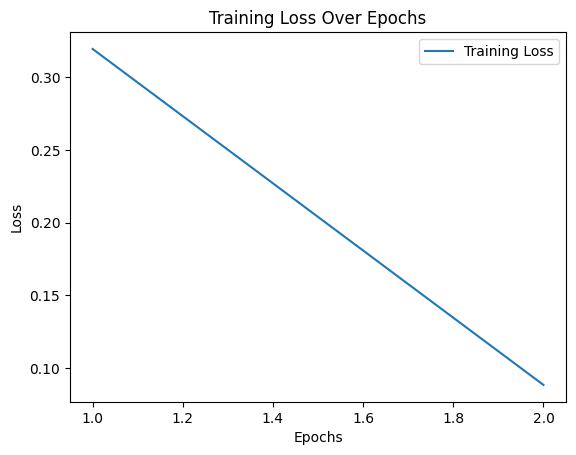

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 훈련 손실을 저장할 리스트
train_losses = []

# 모델 훈련
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch + 1}, Average Training Loss: {avg_epoch_loss}')

    # 각 epoch 이후 모델 저장
    model_save_path = f'distilbert_model_epoch_{epoch + 1}.pt'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved at: {model_save_path}')

# 훈련 손실 그래프 플로팅
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
# 모델 평가
model.eval()
val_preds = []
val_labels = []

In [ ]:
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc='Validation'):
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

Validation: 100%|██████████| 190/190 [07:45<00:00,  2.45s/it]


                precision    recall  f1-score   support

Thyroid_Cancer       0.96      0.97      0.96       584
  Colon_Cancer       0.96      0.95      0.96       516
   Lung_Cancer       1.00      1.00      1.00       414

      accuracy                           0.97      1514
     macro avg       0.97      0.97      0.97      1514
  weighted avg       0.97      0.97      0.97      1514



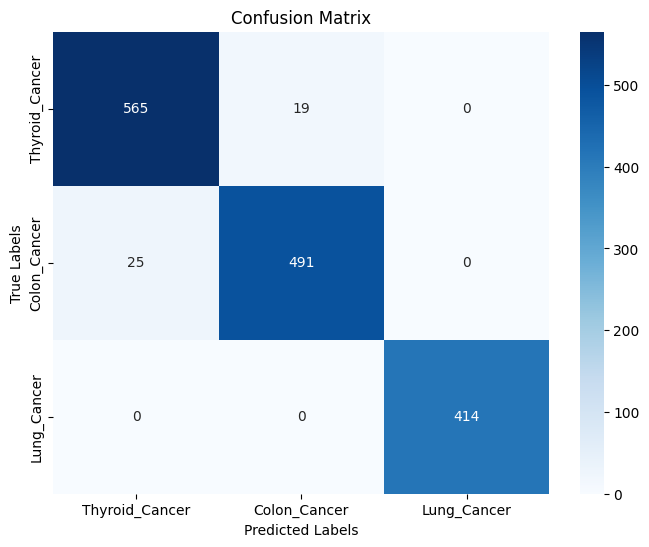

In [ ]:
from sklearn.metrics import confusion_matrix

# 분류 보고서 출력
print(classification_report(val_labels, val_preds, target_names=label_mapping.keys()))

# 혼동 행렬 플로팅
conf_mat = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[565  19   0]
 [ 25 491   0]
 [  0   0 414]]
